In [417]:
from src.plot_maps import plot_map
from matplotlib import colors
from datetime import datetime
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

In [444]:
day = '20200421'
fp = 'maps/final_map_' + day + '.geojson'
map_df = gpd.read_file(fp)

In [445]:
with open("internal_data/lsoa11cd_to_multiple_lookup.csv") as data_file:
    df_regions = pd.read_csv(data_file, low_memory=True, parse_dates=True)

In [446]:
map_df = map_df.merge(df_regions[['lad16cd','country','region']].drop_duplicates(), on='lad16cd', how='left')

In [447]:
map_df.respondent.sum()

1234918.0

In [421]:
wales_map = map_df[map_df.country=='Wales']

In [422]:
actual_cases = pd.read_excel('Rapid COVID-19 surveillance data.xlsx',
                             sheet_name='Tests by specimen date')

In [423]:
new_cases = actual_cases.loc[actual_cases['Specimen date']=='2020-04-01',['Local Authority','Cases (new)']]

In [424]:
wales_map = wales_map.merge(new_cases, right_on='Local Authority', left_on = 'lad16nm', how='left')

In [425]:
wales_map['% Cases (new)'] = wales_map['Cases (new)']/wales_map['population']*1000000

In [426]:
instances_map = wales_map.drop(columns='geometry')

In [427]:
gdf = gpd.GeoDataFrame(instances_map, geometry=gpd.points_from_xy(instances_map.long, instances_map.lat))

In [428]:
gdf.crs = "EPSG:4326"

In [429]:
focus = ['Blaenau Gwent',
        'Brigend',
        'Caerphilly',
        'Cardiff',
        'Merthyr Tydfil',
        'Neath Port Talbot',
        'Newport',
        'Rhondda Cynon Taf',
        'Torfaen',
        'Vale of Glamorgan']

In [430]:
cmap =  colors.ListedColormap(['#f9dee2', '#eabcc5', '#db9ba9', '#cc798d', '#bd5870', '#ae3654', '#a01538'])
boundaries = [0, 1, 2, 3, 4, 5, 6, 10]
norm = colors.BoundaryNorm(boundaries,
                           cmap.N,
                           clip=True)
bins = [1, 2, 3, 4, 5]
labels = ['0.0% - 1.0%', '1.0% - 2.0%', '2.0% - 3.0%','3.0% - 4.0%', '4.0% - 5.0%', '5.0% - 6.0%', '6.0% - 9.0%']

In [431]:
column = 'percentage'

In [432]:
image = {
    'uk': {
        'map': map_df,
        'name': "United Kingdom",
        'figsize': (10,17),
        'supt': 0.93,
        'text_1': [0.18, 0.02],
        'text_2': [0.42, -0.02],
        'logo': [600, 30],
        'legend_pos':'upper left',
        'pad_inches': 0.25
       },
     'wales':{
         'map': wales_map,
            'name': "Wales",
            'figsize': (10,13.5),
            'supt': 0.89,
            'text_1': [0.18, 0.02],
            'text_2': [0.42, -0.03],
            'logo': [700, 30],
            'legend_pos':'upper left',
            'pad_inches': 0.25
     }
}

In [433]:
subtitle = ""
title = ""
day=datetime.strptime(day, "%Y%m%d")

/usr/local/lib/python3.7/site-packages/geopandas/plotting.py:335: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


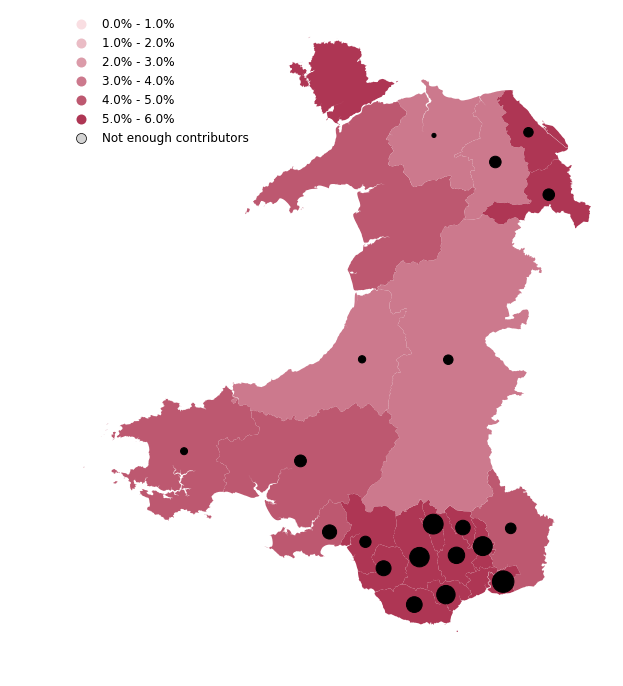

In [434]:
# co-ordinate transformations
target_crs = {'datum': 'WGS84',
              'no_defs': True,
              'proj': 'aea',
              'lat_1': 35,
              'lat_2': 55,
              'lat_0': 45,
              'lon_0': 10}  # UK specific

# plot stuff
fig, ax = plt.subplots(figsize=image['wales']['figsize'])
wales_map.to_crs(crs=target_crs, inplace=True)
gdf.to_crs(crs=target_crs, inplace=True)
f = wales_map.plot(ax=ax,
           column=column,
           cmap=cmap,
           norm=norm,
           scheme='UserDefined',
            missing_kwds={
            "color": "lightgrey",
            "edgecolor": "k",
            "linewidth": 0.7,
            "hatch": "///",
            "label": "Not enough contributors",
           },
           classification_kwds={'bins': bins,},
           legend=True,
           legend_kwds={'title_fontsize':13,'fontsize':12,  'framealpha':0,
                        'loc': image['wales']['legend_pos']})
gdf.plot(ax=ax,
        color='black',
        markersize = '% Cases (new)'
        )

# pretify
plt.title(subtitle, fontsize=13, fontdict={'color':'grey'})
leg = f.get_legend()
for l,t in zip(labels,leg.get_texts()):
    if t.get_text()!='Not enough contributors':
        t.set_text(l)

ax.axis('off')

plt.savefig('/Users/joan-zoe/Desktop/wales_apr_1_new_cases.svg')